**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [1]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 50 kB 2.2 MB/s 


In [2]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np 
import jax.numpy as jn 
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [3]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170508288/170498071 [==============================] - 2s 0us/step



Next we will construct a **Base Model**, which in our case is a small CNN.

In [4]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



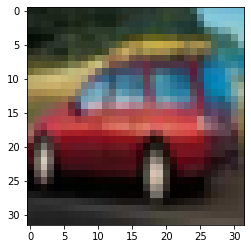

In [5]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [18]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[ 0.08896715 -0.07279256]
   [ 0.5039943  -0.5607323 ]
   [ 0.69289994 -0.86930597]]]]
Conv output: [[[[ 0.14117865  0.13613605  0.11829102 ...  1.0097966   0.9931872
     0.98468655]
   [ 0.19160458  0.16441517  0.16871695 ...  1.0254501   1.0205964
     1.0155538 ]
   [ 0.19664718  0.16639161  0.19392993 ...  1.0188706   1.0191027
     1.0148438 ]
   ...
   [ 0.22187413  0.21178894  0.21178894 ...  0.27654663  0.28158924
     0.29671702]
   [ 0.18657598  0.17649078  0.17649078 ...  0.3068022   0.30175963
     0.30175963]
   [ 0.1664056   0.161363    0.1664056  ...  0.37739852  0.37235594
     0.35722816]]

  [[-0.16435704 -0.15846358 -0.13737418 ... -1.1958665  -1.1757659
    -1.1652533 ]
   [-0.22329159 -0.19162536 -0.19630872 ... -1.2115611  -1.2058
    -1.1999066 ]
   [-0.22918504 -0.1938243  -0.225776   ... -1.2002045  -1.2009761
    -1.196932  ]
   ...
   [-0.259312   -0.24752508 -0.24752508 ... -0.31988704 -0.32578048
    -0.34346086]
   [-0.21805783 -0.20627

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [19]:
# Check dimensions of my-image and filter_weights
my_image_shape = np.shape(my_image)
print(my_image_shape)
filter_weights_shape = np.shape(filter_weights)
print(filter_weights_shape)

(1, 3, 32, 32)
(1, 1, 3, 2)


## (2 points) Fill in the code for your custom convolution filter and show that it returns the same output as Objax’s own convolution routine.

In [20]:
#Solution to the above problem- custom convolution filter   
def my_conv_net(my_image, initial_filter_weights):
  my_image_shape = np.shape(my_image)
  initial_filter_weights_shape = np.shape(initial_filter_weights)
  my_conv_output = np.zeros((my_image_shape[0], initial_filter_weights_shape[3], my_image_shape[2], my_image_shape[3])) 
  nin, nout, W, H = my_image_shape[1], initial_filter_weights_shape[3], my_image_shape[2], my_image_shape[3]
  for a in range(nout):
    for b in range(W):
      for c in range(H):
        for d in range(nin):
          my_conv_output[0][a][b][c] += my_image[0][d][b][c] * initial_filter_weights[0][0][d][a]
  return my_conv_output

print("Filter weights:", filter_weights)
my_conv_output = my_conv_net(my_image, filter_weights)
print("My Conv output:", my_conv_output)
print("My Conv output shape:", np.shape(my_conv_output))

Filter weights: [[[[ 0.08896715 -0.07279256]
   [ 0.5039943  -0.5607323 ]
   [ 0.69289994 -0.86930597]]]]
My Conv output: [[[[ 0.14117865  0.13613605  0.11829101 ...  1.00979662  0.99318719
     0.98468649]
   [ 0.19160458  0.16441518  0.16871697 ...  1.02544999  1.0205965
     1.01555383]
   [ 0.19664718  0.16639161  0.19392993 ...  1.01887059  1.01910257
     1.01484382]
   ...
   [ 0.22187412  0.21178894  0.21178894 ...  0.27654666  0.28158924
     0.29671702]
   [ 0.18657598  0.17649078  0.17649078 ...  0.30680221  0.3017596
     0.3017596 ]
   [ 0.16640559  0.16136301  0.16640559 ...  0.37739855  0.37235594
     0.35722816]]

  [[-0.16435704 -0.15846358 -0.13737418 ... -1.19586647 -1.17576587
    -1.16525328]
   [-0.22329159 -0.19162536 -0.19630872 ... -1.21156096 -1.20580006
    -1.19990659]
   [-0.22918504 -0.19382431 -0.225776   ... -1.20020449 -1.20097613
    -1.19693196]
   ...
   [-0.25931197 -0.24752508 -0.24752508 ... -0.31988704 -0.32578048
    -0.34346083]
   [-0.2180578

In [23]:
# Check that custom convolution operation gives same result as Objax routine
np.linalg.norm(my_conv_output-Conv2d(my_image))
# Since the result of this operation is very small, the two arrays are essentially the same.

9.326973e-07

In [22]:
# Alternatively, this should output true if the two outputs are the same, with some very small tolerance
np.allclose(my_conv_output, Conv2d(my_image))

True

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [26]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

array([[ 0.3549111 , -0.41205535]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



## (1 point) Fill in the code for your linear layer, and show that it returns the same output as passing through Objax’s own linear layer.


In [31]:
# Obtain output Y by passing my_conv_output through Objax's own linear layer
Linear_Layer = objax.nn.Linear(2, 1)
Y1 = Linear_Layer(my_conv_output.mean((2,3)))

# This is the one-liner. Y2 is result of manually implementing linear layer.
Y2 = np.dot(my_conv_output.mean((2,3)), Linear_Layer.w.value) + Linear_Layer.b.value

# Print both Y1 and Y2
print(Y1)
print(Y2)
# Since the output is the exact same, we have shown that our code for the linear layer returns the same output as passing through Objax's own linear layer.

[[0.36433485]]
[[0.36433485]]


You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

## (1 point) Complete the optimizer by using the definition of (stochastic) gradient descent. Note that you need to update params.value, which are the values of the trainable variables of your model.


In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr * grad)  # PUT CODE HERE                  
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

## (1 point) Complete the batch sampling code in the train function by specifying a batch of examples. You should make use the lists train indices and val indices.

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = [] 
  train_acc_epoch = [] 
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] # put code here
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] # put code here
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

## (1 point) Train the model for a few epochs, and observe the training/validation loss and training/validation accuracy plots. Include these plots within the PDF you hand in.
## You should observe that the validation accuracy is low and stagnates after a few epochs. Next we will go through a rudimentary way of adjusting the hyperparameters of the model which we created

Epoch 0001  Training Loss 2.30 Validation Loss 2.28 Training Accuracy 10.01 Validation Accuracy 10.35
Epoch 0002  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 10.85 Validation Accuracy 11.68
Epoch 0003  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 11.82 Validation Accuracy 12.48
Epoch 0004  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 12.68 Validation Accuracy 13.02
Epoch 0005  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 13.50 Validation Accuracy 13.75
Epoch 0006  Training Loss 2.24 Validation Loss 2.23 Training Accuracy 14.12 Validation Accuracy 14.35
Epoch 0007  Training Loss 2.23 Validation Loss 2.22 Training Accuracy 14.77 Validation Accuracy 15.62
Epoch 0008  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 16.17 Validation Accuracy 17.03
Epoch 0009  Training Loss 2.20 Validation Loss 2.20 Training Accuracy 17.37 Validation Accuracy 17.05
Epoch 0010  Training Loss 2.19 Validation Loss 2.18 Training Accuracy 17.85 Valida

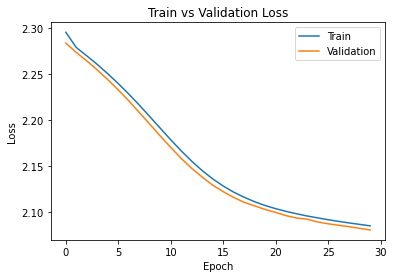

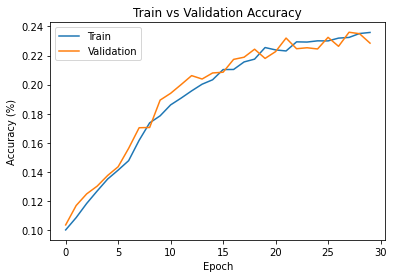

In [ ]:
train(30)

Follow the assignment handout for questions to be answered in this part of the assignment.

## (2 points) Select 4 hyperparameters associated with your network, one of the hyperparameters must involve your CNN architecture, and come up with two different sets of hyperparameters.

### Hyperparameters
#### The 4 hyperparameters we will consider are number of output channels in convolution layer 1, batch size, learning rate and activation function



## Create two additional networks M1, M2, each with the set of hyperparameter H1, H2 that you have selected above. Train each model.

### Hyperparameter Setting 1:     
### # output channels in conv layer 1 = 24
### batch_size = 32
### learning_rate = 0.005
### activation function: sigmoid

In [ ]:
class M1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 24, 2), objax.functional.sigmoid])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(24, 32, 2), objax.functional.sigmoid])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model1 = M1()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of cross entropies
def loss_function1(x, labels):
    logit = model1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict1 = objax.Jit(lambda x: objax.functional.softmax(model1(x)), model1.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv1 = objax.GradValues(loss_function1, model1.vars())

#Create an object that can be used to provide trainable variables in the model
tv1 = objax.ModuleList(objax.TrainRef(x) for x in model1.vars().subset(objax.TrainVar))

#Training routine
def train_op1(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv1(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv1.vars()):
      params.assign(params.value - lr * grad)                    
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op1 = objax.Jit(train_op1, gv1.vars() + tv1.vars())

In [ ]:
def train1(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.005):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = [] 
  train_acc_epoch = [] 
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] # put code here
          avg_train_loss += float(train_op1(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict1(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] # put code here
          avg_val_loss += float(loss_function1(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict1(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 10.33 Validation Accuracy 10.75
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.94 Validation Accuracy 11.27
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.22 Validation Accuracy 12.07
Epoch 0004  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.72 Validation Accuracy 9.63
Epoch 0005  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.42 Validation Accuracy 9.70
Epoch 0006  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.29 Validation Accuracy 10.55
Epoch 0007  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.46 Validation Accuracy 14.32
Epoch 0008  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 14.34 Validation Accuracy 13.15
Epoch 0009  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 14.91 Validation Accuracy 15.85
Epoch 0010  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 15.43 Validati

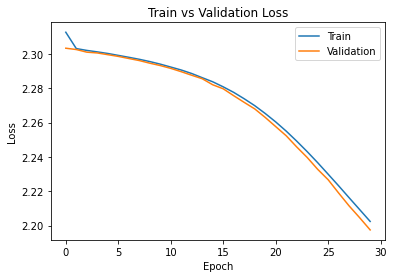

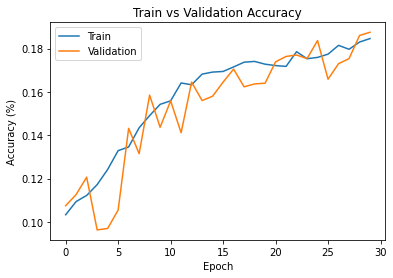

In [ ]:
train1(30) 

### Hyperparameter Setting 2:     
### # output channels in conv layer 1 = 32
### batch_size = 64
### learning_rate = 0.01
### activation function: tanh

In [ ]:
class M2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.tanh])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.tanh])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model2 = M2()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of cross entropies
def loss_function2(x, labels):
    logit = model2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict2 = objax.Jit(lambda x: objax.functional.softmax(model2(x)), model2.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv2 = objax.GradValues(loss_function2, model2.vars())

#Create an object that can be used to provide trainable variables in the model
tv2 = objax.ModuleList(objax.TrainRef(x) for x in model2.vars().subset(objax.TrainVar))

#Training routine
def train_op2(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv2(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv2.vars()):
      params.assign(params.value - lr * grad)                    
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op2 = objax.Jit(train_op2, gv2.vars() + tv2.vars())

In [ ]:
def train2(EPOCHS = 20, BATCH = 64, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = [] 
  train_acc_epoch = [] 
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] # put code here
          avg_train_loss += float(train_op2(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict2(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] # put code here
          avg_val_loss += float(loss_function2(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict2(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.29 Validation Loss 2.26 Training Accuracy 13.91 Validation Accuracy 17.32
Epoch 0002  Training Loss 2.24 Validation Loss 2.20 Training Accuracy 19.89 Validation Accuracy 22.73
Epoch 0003  Training Loss 2.16 Validation Loss 2.12 Training Accuracy 23.18 Validation Accuracy 24.23
Epoch 0004  Training Loss 2.10 Validation Loss 2.08 Training Accuracy 24.62 Validation Accuracy 24.75
Epoch 0005  Training Loss 2.07 Validation Loss 2.05 Training Accuracy 25.11 Validation Accuracy 24.38
Epoch 0006  Training Loss 2.04 Validation Loss 2.03 Training Accuracy 25.60 Validation Accuracy 25.67
Epoch 0007  Training Loss 2.03 Validation Loss 2.02 Training Accuracy 26.13 Validation Accuracy 26.85
Epoch 0008  Training Loss 2.01 Validation Loss 2.00 Training Accuracy 27.00 Validation Accuracy 26.12
Epoch 0009  Training Loss 1.99 Validation Loss 1.98 Training Accuracy 27.27 Validation Accuracy 27.80
Epoch 0010  Training Loss 1.98 Validation Loss 1.97 Training Accuracy 28.06 Valida

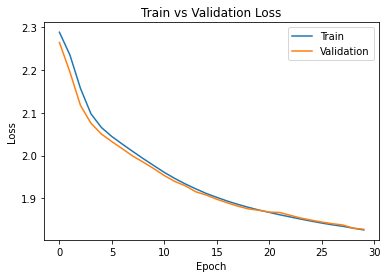

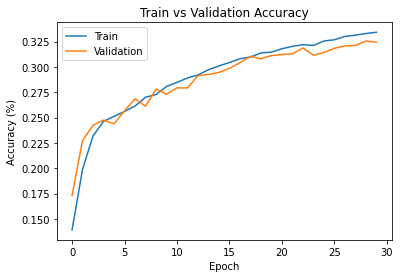

In [ ]:
train2(30)

## Report the best validation accuracy as well as the corresponding epoch for which this occurs for the Base Model and your two additional models.

Base Model: 23.60% at epoch 28\
M1: 18.75% at epoch 30\
M2: 32.55% at epoch 29

Pick M2 (see reasoning in written section)

In [ ]:
# Pick the last model
# eval model on test set, report test set accuracy 
mean_test_loss = float(loss_function2(X_test, Y_test)) 
print('Mean Test Loss: %.2f' % (mean_test_loss))

test_prediction = predict2(X_test).argmax(1)
test_acc = ((np.array(test_prediction).flatten() == Y_test).sum())/X_test.shape[0]
print('Test set accuracy: %.2f' % (test_acc*100))

Mean Test Loss: 1.83
Test set accuracy: 32.88


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


## (1 point) Import and partition your data.

In [32]:
# I have picked MNIST dataset
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train = np.expand_dims(X_train, 1)
X_train = X_train / 255.0
X_test = np.expand_dims(X_test, 1)
X_test = X_test / 255.0

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

11501568/11490434 [==============================] - 0s 0us/step


## (1 point) Create a base model to start out with

In [ ]:
class MNISTConvNet(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2) 
    x = self.conv_2(x) 
    
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x) 
    return x 

#The following line creates the CNN
mnist_model = MNISTConvNet()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def mnist_loss_function(x, labels):
    logit = mnist_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
mnist_predict = objax.Jit(lambda x: objax.functional.softmax(mnist_model(x)), mnist_model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
mnist_gv= objax.GradValues(mnist_loss_function, mnist_model.vars())

#Create an object that can be used to provide trainable variables in the model
mnist_tv = objax.ModuleList(objax.TrainRef(x) for x in mnist_model.vars().subset(objax.TrainVar))

#Training routine
def mnist_train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = mnist_gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, mnist_tv.vars()):
      params.assign(params.value - lr * grad)                    
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
mnist_train_op = objax.Jit(mnist_train_op, mnist_gv.vars() + mnist_tv.vars())

In [ ]:
def mnist_train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = [] 
  train_acc_epoch = [] 
  val_acc_epoch = []
  
  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] # put code here
          avg_train_loss += float(mnist_train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = mnist_predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] # put code here
          avg_val_loss += float(mnist_loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = mnist_predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 9.05 Validation Accuracy 8.71
Epoch 0002  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 12.41 Validation Accuracy 14.74
Epoch 0003  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 16.01 Validation Accuracy 14.77
Epoch 0004  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 16.18 Validation Accuracy 17.03
Epoch 0005  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 18.07 Validation Accuracy 18.21
Epoch 0006  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 18.88 Validation Accuracy 18.99
Epoch 0007  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 19.62 Validation Accuracy 19.43
Epoch 0008  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 20.10 Validation Accuracy 19.84
Epoch 0009  Training Loss 2.24 Validation Loss 2.24 Training Accuracy 20.60 Validation Accuracy 20.14
Epoch 0010  Training Loss 2.23 Validation Loss 2.23 Training Accuracy 20.77 Validati

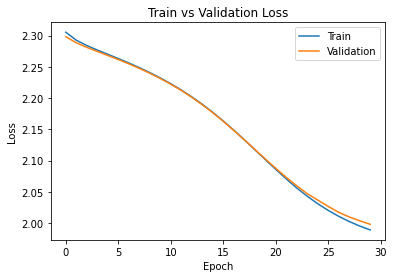

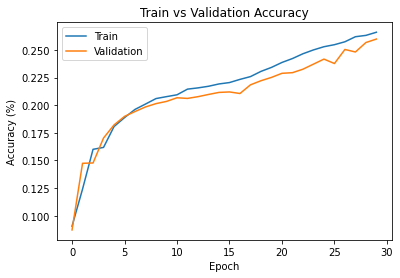

In [ ]:
mnist_train(30)

## MNISTConvNetTuned class allows you to pass more model architecture settings as parameters, which will be useful later in hyperparameter tuning

In [33]:
class MNISTConvNetTuned(objax.Module): 
  def __init__(self, number_of_channels = 1, number_of_classes = 10, numchannels1=16, numchannels2=32, activationfctnlayer1='relu', activationfctnlayer2='relu', k1=2, k2=2):
    if activationfctnlayer1 == 'relu':
      self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, numchannels1, k1), objax.functional.relu])
    elif activationfctnlayer1 == 'sigmoid':
      self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, numchannels1, k1), objax.functional.sigmoid])
    else:
      self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, numchannels1, k1), objax.functional.tanh])

    if activationfctnlayer2 == 'relu':
      self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(numchannels1, numchannels2, k2), objax.functional.relu])
    elif activationfctnlayer2 == 'sigmoid':
      self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(numchannels1, numchannels2, k2), objax.functional.sigmoid])
    else:
      self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(numchannels1, numchannels2, k2), objax.functional.tanh])

    self.linear = objax.nn.Linear(numchannels2, number_of_classes)

  def __call__(self, x, pool_dim1=2, pool_dim2=2):
    x = objax.functional.max_pool_2d(self.conv_1(x), pool_dim1, pool_dim2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

## Train function allows you to pass hyperparameters, allowing us to easily try out different hyperparameter settings

In [34]:
def mnist_tuned_train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4, number_of_channels = 1, number_of_classes = 10, numchannels1=16, numchannels2=32, activationfctnlayer1='relu', activationfctnlayer2='relu', k1=2, k2=2, pool_dim1=2, pool_dim2=2):
  tuned_mnist_model = MNISTConvNetTuned(number_of_channels, number_of_classes, numchannels1, numchannels2, activationfctnlayer1, activationfctnlayer2, k1, k2)

  def tuned_loss_function(x, labels):
      logit = tuned_mnist_model(x, pool_dim1, pool_dim2)
      return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

  #Define a prediction function
  tuned_mnist_predict = objax.Jit(lambda x: objax.functional.softmax(tuned_mnist_model(x, pool_dim1, pool_dim2)), tuned_mnist_model.vars()) 

  #Create an object that can be used to calculate the gradient and value of loss_function
  tuned_mnist_gv= objax.GradValues(tuned_loss_function, tuned_mnist_model.vars())

  #Create an object that can be used to provide trainable variables in the model
  tuned_mnist_tv = objax.ModuleList(objax.TrainRef(x) for x in tuned_mnist_model.vars().subset(objax.TrainVar))

  #Training routine
  def tuned_mnist_train_op(x, y, learning_rate):
      lr = learning_rate
      gradient, loss_value = tuned_mnist_gv(x, y)   # calculate gradient and loss value "backprop"
      #next we update the trainable parameter using SGD and similar procedure
      for grad, params in zip(gradient, tuned_mnist_tv.vars()):
        params.assign(params.value - lr * grad)                    
      return loss_value                      # return loss value

  #make train_op (much) faster using JIT compilation
  tuned_mnist_train_op = objax.Jit(tuned_mnist_train_op, tuned_mnist_gv.vars() + tuned_mnist_tv.vars())

  avg_train_loss_epoch = []
  avg_val_loss_epoch = [] 
  train_acc_epoch = [] 
  val_acc_epoch = []
  
  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] # put code here
          avg_train_loss += float(tuned_mnist_train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = tuned_mnist_predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] # put code here
          avg_val_loss += float(tuned_loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = tuned_mnist_predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      if epoch % 5 == 4:
        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

  return tuned_mnist_model

## (3 points) Pick several hyperparameters you would like to tune and train a model until its validation accuracy is 5-10% better than the base model. Provide a succinct discussion on your design procedure: which hyperparameters you tuned, what is the new validation accuracy.


### My design procedure is not recommended in general for machine learning applications, but successfully achieves 5-10% better than base model. My procedure involves tuning on hyperparameter at a time, stopping when we see satisfactory improvement. In practical examples, I would perform either grid search or random search to obtain the optimal hyperparameters, but my method is a straightforward and reasonable way to reach the small 5-10% improvement. It is also easier to track in terms of the effect each single hyperparameter has (while random, you won't know what hyperparameter or set of hyperparameters that you changed resulted in validation accuracy improvements or worsenings)

### Batch_size

Epoch 0005  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 20.97 Validation Accuracy 21.11
Epoch 0010  Training Loss 2.12 Validation Loss 2.10 Training Accuracy 23.45 Validation Accuracy 23.14
Epoch 0015  Training Loss 1.96 Validation Loss 1.96 Training Accuracy 28.29 Validation Accuracy 27.24
Epoch 0020  Training Loss 1.91 Validation Loss 1.92 Training Accuracy 31.10 Validation Accuracy 29.59
Epoch 0025  Training Loss 1.85 Validation Loss 1.85 Training Accuracy 33.79 Validation Accuracy 32.00
Epoch 0030  Training Loss 1.75 Validation Loss 1.75 Training Accuracy 37.61 Validation Accuracy 37.39


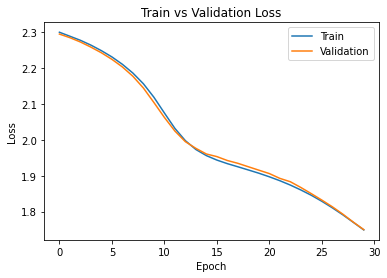

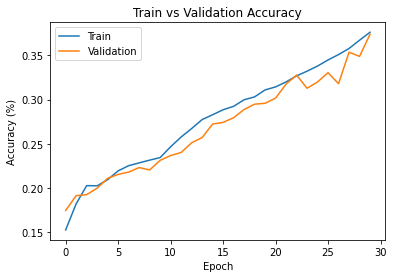

In [ ]:
# Batch_size = 8. Start at base model, and change batch size
m1 = mnist_tuned_train(30, 8, 9e-4, 1, 10, 16, 32, 'relu', 'relu', 2, 2, 2)

Epoch 0005  Training Loss 2.29 Validation Loss 2.30 Training Accuracy 11.35 Validation Accuracy 10.70
Epoch 0010  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 12.49 Validation Accuracy 13.09
Epoch 0015  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 15.09 Validation Accuracy 14.14
Epoch 0020  Training Loss 2.26 Validation Loss 2.27 Training Accuracy 17.54 Validation Accuracy 18.54
Epoch 0025  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 19.99 Validation Accuracy 18.90
Epoch 0030  Training Loss 2.23 Validation Loss 2.23 Training Accuracy 20.78 Validation Accuracy 20.13


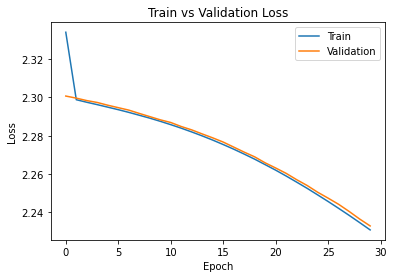

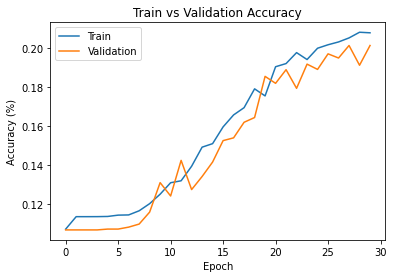

In [ ]:
# Batch_size = 16
m2 = mnist_tuned_train(30, 16, 9e-4, 1, 10, 16, 32, 'relu', 'relu', 2, 2, 2)

In [ ]:
# Batch_size = 32
# SAME AS BASE CNN MODEL
#mnist_tuned_train(30, 32, 9e-4, 1, 10, 16, 32, 'relu', 'sigmoid', 2, 2, 2)

Epoch 0005  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.05 Validation Accuracy 10.66
Epoch 0010  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0015  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0020  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0025  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0030  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66


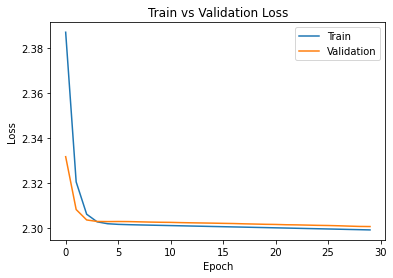

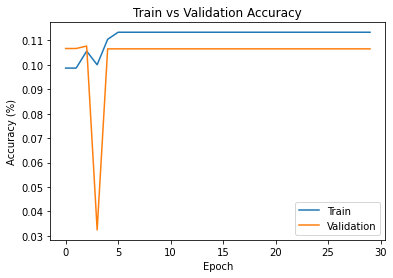

In [ ]:
# Batch_size = 64
m3 = mnist_tuned_train(30, 64, 9e-4, 1, 10, 16, 32, 'relu', 'relu', 2, 2, 2)

## Learning Rate

Epoch 0005  Training Loss 1.87 Validation Loss 1.84 Training Accuracy 34.08 Validation Accuracy 32.94
Epoch 0010  Training Loss 1.29 Validation Loss 1.25 Training Accuracy 58.75 Validation Accuracy 57.36
Epoch 0015  Training Loss 1.12 Validation Loss 1.10 Training Accuracy 65.51 Validation Accuracy 61.09
Epoch 0020  Training Loss 1.03 Validation Loss 1.02 Training Accuracy 69.64 Validation Accuracy 63.61
Epoch 0025  Training Loss 0.94 Validation Loss 0.92 Training Accuracy 73.20 Validation Accuracy 68.43
Epoch 0030  Training Loss 0.86 Validation Loss 0.83 Training Accuracy 76.48 Validation Accuracy 71.89


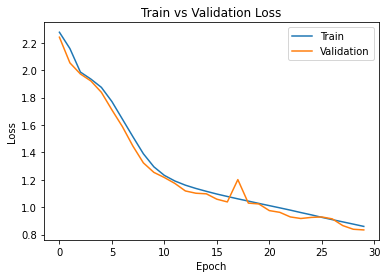

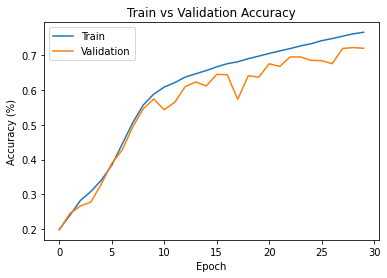

In [ ]:
# Learning Rate = 0.005
m4 = mnist_tuned_train(30, 8, 0.005, 1, 10, 16, 32, 'relu', 'relu', 2, 2, 2)

Epoch 0005  Training Loss 1.36 Validation Loss 1.27 Training Accuracy 57.75 Validation Accuracy 54.84
Epoch 0010  Training Loss 0.98 Validation Loss 0.91 Training Accuracy 74.86 Validation Accuracy 70.14
Epoch 0015  Training Loss 0.79 Validation Loss 0.73 Training Accuracy 80.61 Validation Accuracy 76.74
Epoch 0020  Training Loss 0.68 Validation Loss 0.63 Training Accuracy 84.32 Validation Accuracy 80.34
Epoch 0025  Training Loss 0.61 Validation Loss 0.59 Training Accuracy 86.94 Validation Accuracy 81.30
Epoch 0030  Training Loss 0.55 Validation Loss 0.50 Training Accuracy 88.94 Validation Accuracy 84.31


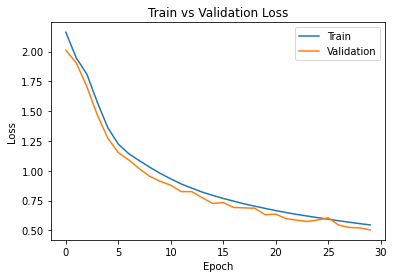

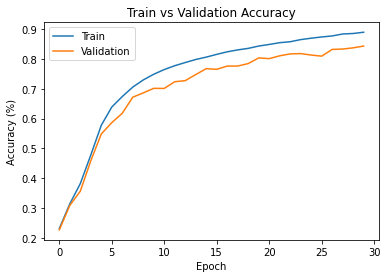

In [ ]:
# Learning Rate = 0.01
m5 = mnist_tuned_train(30, 8, 0.01, 1, 10, 16, 32, 'relu', 'relu', 2, 2, 2)

Epoch 0005  Training Loss 0.72 Validation Loss 0.65 Training Accuracy 87.32 Validation Accuracy 78.00
Epoch 0010  Training Loss 0.44 Validation Loss 0.43 Training Accuracy 93.87 Validation Accuracy 86.73
Epoch 0015  Training Loss 0.36 Validation Loss 0.31 Training Accuracy 95.56 Validation Accuracy 90.21
Epoch 0020  Training Loss 0.30 Validation Loss 0.28 Training Accuracy 96.21 Validation Accuracy 91.47
Epoch 0025  Training Loss 0.27 Validation Loss 0.30 Training Accuracy 96.61 Validation Accuracy 90.43
Epoch 0030  Training Loss 0.25 Validation Loss 0.22 Training Accuracy 96.96 Validation Accuracy 92.93


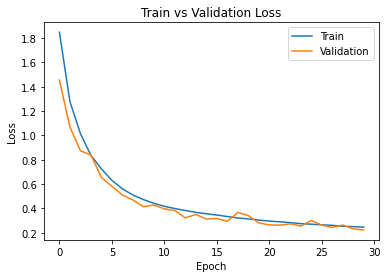

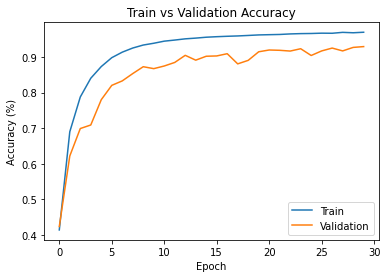

In [ ]:
# Learning Rate = 0.05
m6 = mnist_tuned_train(30, 8, 0.05, 1, 10, 16, 32, 'relu', 'relu', 2, 2, 2)

Epoch 0005  Training Loss 0.57 Validation Loss 0.47 Training Accuracy 92.93 Validation Accuracy 85.30
Epoch 0010  Training Loss 0.35 Validation Loss 0.39 Training Accuracy 96.73 Validation Accuracy 86.89
Epoch 0015  Training Loss 0.27 Validation Loss 0.28 Training Accuracy 97.52 Validation Accuracy 91.16
Epoch 0020  Training Loss 0.24 Validation Loss 0.20 Training Accuracy 97.77 Validation Accuracy 93.71
Epoch 0025  Training Loss 0.22 Validation Loss 0.19 Training Accuracy 97.98 Validation Accuracy 94.14
Epoch 0030  Training Loss 0.20 Validation Loss 0.20 Training Accuracy 98.13 Validation Accuracy 93.89


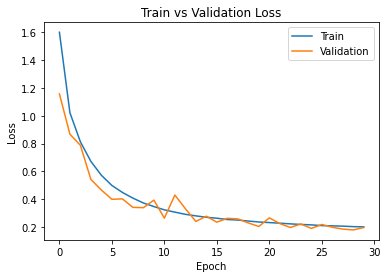

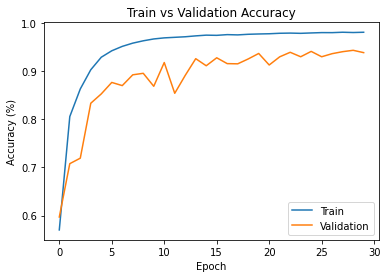

In [45]:
# Learning Rate = 0.1
m7 = mnist_tuned_train(30, 8, 0.1, 1, 10, 16, 32, 'relu', 'relu', 2, 2, 2)

## (1 point) Select your final model and report test accuracy

In [46]:
# eval model on test set, report test set accuracy 
final_model = m7 # since gave highest val accuracy

logit = final_model(X_test, 2) #pool_dim=2
mean_test_loss = objax.functional.loss.cross_entropy_logits_sparse(logit, Y_test).mean()
print('Mean Test Loss: %.2f' % (mean_test_loss))

final_predict = objax.Jit(lambda x: objax.functional.softmax(final_model(x, 2)), final_model.vars()) 
test_prediction = final_predict(X_test).argmax(1)
test_acc = ((np.array(test_prediction).flatten() == Y_test).sum())/X_valid.shape[0]
print('Test set accuracy: %.2f' % (test_acc*100))

Mean Test Loss: 0.21
Test set accuracy: 93.49


##**Problem 4. Open-Ended Exploration**

See the handout for instructions.

###1. Additional hyperparameter tuning 

## Adjust Kernel/filter size of each layer

Epoch 0005  Training Loss 1.86 Validation Loss 1.83 Training Accuracy 34.55 Validation Accuracy 32.86
Epoch 0010  Training Loss 1.30 Validation Loss 1.24 Training Accuracy 58.87 Validation Accuracy 57.00
Epoch 0015  Training Loss 1.08 Validation Loss 1.05 Training Accuracy 68.40 Validation Accuracy 64.93
Epoch 0020  Training Loss 0.94 Validation Loss 0.90 Training Accuracy 74.86 Validation Accuracy 71.13
Epoch 0025  Training Loss 0.84 Validation Loss 0.80 Training Accuracy 77.88 Validation Accuracy 73.51
Epoch 0030  Training Loss 0.77 Validation Loss 0.73 Training Accuracy 80.17 Validation Accuracy 76.76


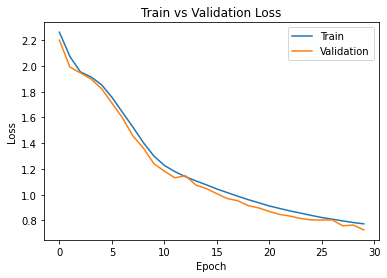

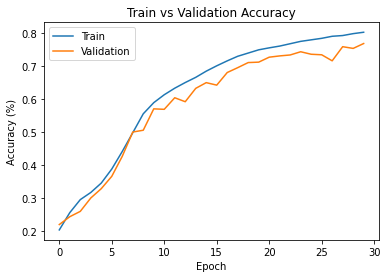

In [ ]:
base_model = mnist_tuned_train(30, 8, 0.005, 1, 10, 16, 32, 'relu', 'relu', 2, 2, 2) # val accuracy of 71.89% from before, but could vary per run depending on random parameter initializations

In [ ]:
logit = base_model(X_test, 2) #pool_dim=2
mean_test_loss = objax.functional.loss.cross_entropy_logits_sparse(logit, Y_test).mean()
print('Mean Test Loss: %.2f' % (mean_test_loss))

base_predict = objax.Jit(lambda x: objax.functional.softmax(base_model(x, 2)), base_model.vars()) 
test_prediction = base_predict(X_test).argmax(1)
test_acc = ((np.array(test_prediction).flatten() == Y_test).sum())/X_test.shape[0]
print('Test set accuracy: %.2f' % (test_acc*100))

Mean Test Loss: 0.75
Test set accuracy: 76.47


Epoch 0005  Training Loss 1.73 Validation Loss 1.64 Training Accuracy 40.69 Validation Accuracy 39.16
Epoch 0010  Training Loss 1.13 Validation Loss 1.09 Training Accuracy 64.86 Validation Accuracy 63.51
Epoch 0015  Training Loss 0.86 Validation Loss 0.83 Training Accuracy 77.31 Validation Accuracy 73.71
Epoch 0020  Training Loss 0.64 Validation Loss 0.61 Training Accuracy 84.73 Validation Accuracy 81.80
Epoch 0025  Training Loss 0.51 Validation Loss 0.49 Training Accuracy 88.67 Validation Accuracy 85.43
Epoch 0030  Training Loss 0.44 Validation Loss 0.46 Training Accuracy 90.75 Validation Accuracy 85.84


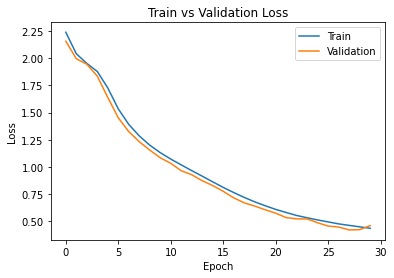

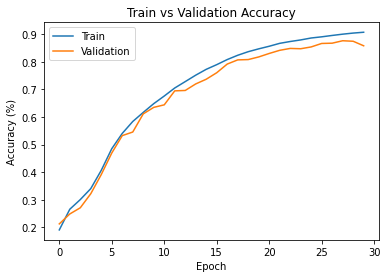

In [ ]:
model1 = mnist_tuned_train(30, 8, 0.005, 1, 10, 16, 32, 'relu', 'relu', 3, 2, 2)

Epoch 0005  Training Loss 1.41 Validation Loss 1.32 Training Accuracy 58.31 Validation Accuracy 53.54
Epoch 0010  Training Loss 0.83 Validation Loss 0.77 Training Accuracy 81.33 Validation Accuracy 76.66
Epoch 0015  Training Loss 0.59 Validation Loss 0.57 Training Accuracy 89.01 Validation Accuracy 81.80
Epoch 0020  Training Loss 0.46 Validation Loss 0.42 Training Accuracy 92.28 Validation Accuracy 87.37
Epoch 0025  Training Loss 0.39 Validation Loss 0.39 Training Accuracy 94.23 Validation Accuracy 88.41
Epoch 0030  Training Loss 0.34 Validation Loss 0.32 Training Accuracy 95.23 Validation Accuracy 90.33


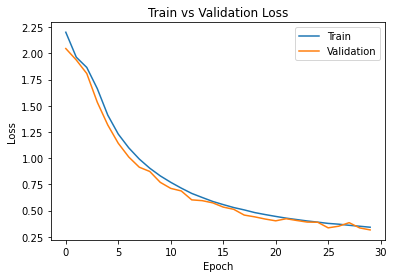

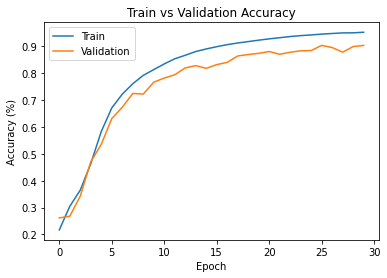

In [ ]:
model2 = mnist_tuned_train(30, 8, 0.005, 1, 10, 16, 32, 'relu', 'relu', 2, 3, 2)

Epoch 0005  Training Loss 1.26 Validation Loss 1.16 Training Accuracy 62.54 Validation Accuracy 61.90
Epoch 0010  Training Loss 0.57 Validation Loss 0.52 Training Accuracy 88.19 Validation Accuracy 85.19
Epoch 0015  Training Loss 0.39 Validation Loss 0.37 Training Accuracy 92.94 Validation Accuracy 89.16
Epoch 0020  Training Loss 0.31 Validation Loss 0.31 Training Accuracy 94.81 Validation Accuracy 90.84
Epoch 0025  Training Loss 0.27 Validation Loss 0.25 Training Accuracy 95.93 Validation Accuracy 92.43
Epoch 0030  Training Loss 0.24 Validation Loss 0.24 Training Accuracy 96.40 Validation Accuracy 92.84


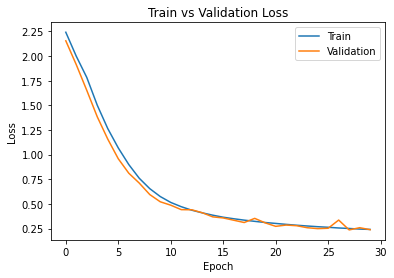

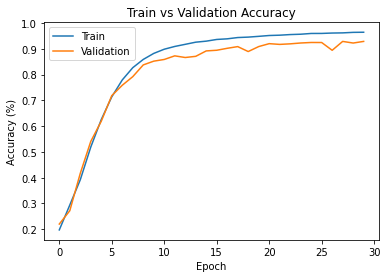

In [ ]:
model3 = mnist_tuned_train(30, 8, 0.005, 1, 10, 16, 32, 'relu', 'relu', 3, 3, 2)

Epoch 0005  Training Loss 0.56 Validation Loss 0.47 Training Accuracy 88.77 Validation Accuracy 86.91
Epoch 0010  Training Loss 0.26 Validation Loss 0.28 Training Accuracy 96.08 Validation Accuracy 91.79
Epoch 0015  Training Loss 0.19 Validation Loss 0.20 Training Accuracy 97.27 Validation Accuracy 94.37
Epoch 0020  Training Loss 0.16 Validation Loss 0.16 Training Accuracy 97.82 Validation Accuracy 94.99
Epoch 0025  Training Loss 0.14 Validation Loss 0.20 Training Accuracy 98.05 Validation Accuracy 93.84
Epoch 0030  Training Loss 0.13 Validation Loss 0.13 Training Accuracy 98.25 Validation Accuracy 96.19


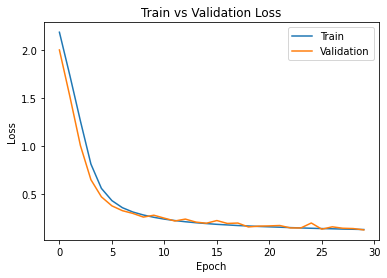

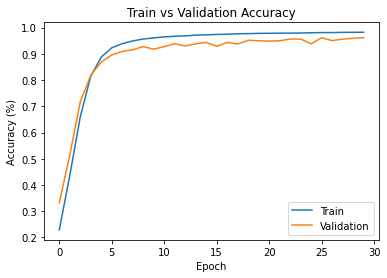

In [ ]:
model4 = mnist_tuned_train(30, 8, 0.005, 1, 10, 16, 32, 'relu', 'relu', 4, 4, 2)

Epoch 0005  Training Loss 0.45 Validation Loss 0.44 Training Accuracy 92.99 Validation Accuracy 86.57
Epoch 0010  Training Loss 0.26 Validation Loss 0.26 Training Accuracy 96.75 Validation Accuracy 92.33
Epoch 0015  Training Loss 0.20 Validation Loss 0.22 Training Accuracy 97.66 Validation Accuracy 93.91
Epoch 0020  Training Loss 0.17 Validation Loss 0.17 Training Accuracy 98.12 Validation Accuracy 95.09
Epoch 0025  Training Loss 0.15 Validation Loss 0.15 Training Accuracy 98.27 Validation Accuracy 95.66
Epoch 0030  Training Loss 0.13 Validation Loss 0.13 Training Accuracy 98.58 Validation Accuracy 95.94


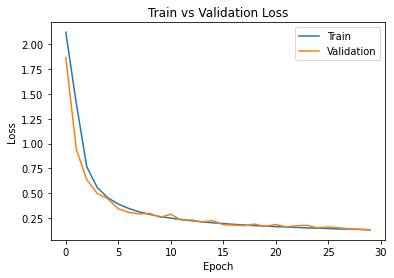

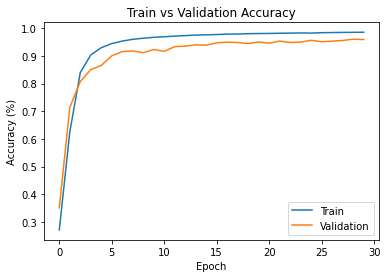

In [ ]:
model5 = mnist_tuned_train(30, 8, 0.005, 1, 10, 16, 32, 'relu', 'relu', 4, 4, 2, 4)

Epoch 0005  Training Loss 0.31 Validation Loss 0.27 Training Accuracy 96.13 Validation Accuracy 92.24
Epoch 0010  Training Loss 0.19 Validation Loss 0.19 Training Accuracy 97.82 Validation Accuracy 94.34
Epoch 0015  Training Loss 0.15 Validation Loss 0.15 Training Accuracy 98.24 Validation Accuracy 95.53
Epoch 0020  Training Loss 0.13 Validation Loss 0.15 Training Accuracy 98.55 Validation Accuracy 95.66
Epoch 0025  Training Loss 0.12 Validation Loss 0.11 Training Accuracy 98.65 Validation Accuracy 96.67
Epoch 0030  Training Loss 0.11 Validation Loss 0.11 Training Accuracy 98.80 Validation Accuracy 96.89


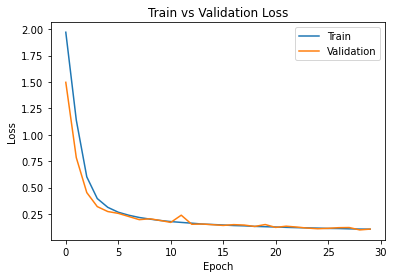

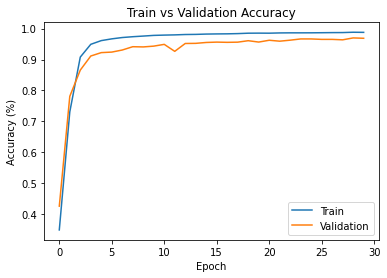

In [ ]:
model6 = mnist_tuned_train(30, 8, 0.005, 1, 10, 16, 32, 'relu', 'relu', 4, 4, 4, 2)

Epoch 0005  Training Loss 0.32 Validation Loss 0.32 Training Accuracy 95.10 Validation Accuracy 90.80
Epoch 0010  Training Loss 0.19 Validation Loss 0.19 Training Accuracy 97.39 Validation Accuracy 94.51
Epoch 0015  Training Loss 0.15 Validation Loss 0.14 Training Accuracy 98.02 Validation Accuracy 95.73
Epoch 0020  Training Loss 0.12 Validation Loss 0.14 Training Accuracy 98.47 Validation Accuracy 95.71
Epoch 0025  Training Loss 0.11 Validation Loss 0.11 Training Accuracy 98.72 Validation Accuracy 96.59
Epoch 0030  Training Loss 0.10 Validation Loss 0.11 Training Accuracy 98.84 Validation Accuracy 96.59


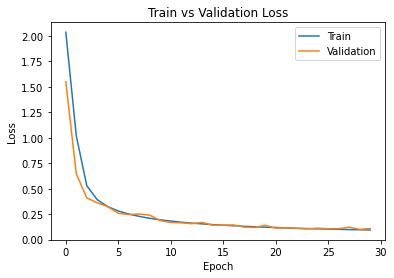

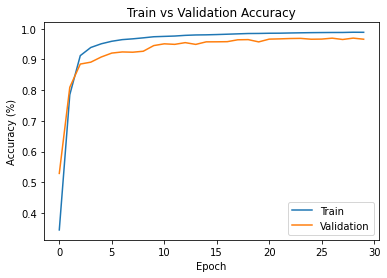

In [ ]:
model7 = mnist_tuned_train(30, 8, 0.005, 1, 10, 16, 32, 'relu', 'relu', 4, 4, 4, 4)

In [ ]:
logit = model6(X_test, 4, 2) #pool_dim=2
mean_test_loss = objax.functional.loss.cross_entropy_logits_sparse(logit, Y_test).mean()
print('Mean Test Loss: %.2f' % (mean_test_loss))

final_predict = objax.Jit(lambda x: objax.functional.softmax(model6(x, 4, 2)), model6.vars()) 
test_prediction = final_predict(X_test).argmax(1)
test_acc = ((np.array(test_prediction).flatten() == Y_test).sum())/X_test.shape[0]
print('Test set accuracy: %.2f' % (test_acc*100))

Mean Test Loss: 0.10
Test set accuracy: 96.91
